# Preprocessing Data: DataFrame with Pandas

The data is split into 2 CSV files, true and fake news. We will first view the two files seperately and then merge in order to split into train and test datasets. 

In [1]:
from google.colab import files
uploaded = files.upload()

Saving true_news.csv to true_news (2).csv
Saving fake_news.csv to fake_news (2).csv


In [2]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import dependencies
import io
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

from collections import Counter
import seaborn as sns

from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#  Import and read the Fake.csv.
fake_news_df = pd.read_csv(io.BytesIO(uploaded['fake_news.csv']))
fake_news_df.head()

,title,text,subject,date,year
0,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,2018-02-14,2018
1,POLITICS FIRST: LEFTIST PARENTS Of Former Comb...,The heartbreaking story of two parents who put...,politics,2018-02-15,2018
2,TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...,ABC News When two Marjory Stoneman Douglas Hi...,politics,2018-02-15,2018
3,MEDIA PROMOTES Fake News That Shooter Connecte...,The mainstream media is guilty of fake news wh...,politics,2018-02-15,2018
4,"WHAT’S WRONG WITH PELOSI? Nancy Stutters, Stam...",What s wrong with Pelosi? Nancy Pelosi is supp...,politics,2018-02-15,2018


Add 'title' length to fake news df

In [5]:
fake_news_df['title_length']  = fake_news_df['title'].str.len()

In [6]:
fake_news_df.head()

,title,text,subject,date,year,title_length
0,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,We ve been covering the curious case of DOJ of...,politics,2018-02-14,2018,115
1,POLITICS FIRST: LEFTIST PARENTS Of Former Comb...,The heartbreaking story of two parents who put...,politics,2018-02-15,2018,126
2,TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...,ABC News When two Marjory Stoneman Douglas Hi...,politics,2018-02-15,2018,154
3,MEDIA PROMOTES Fake News That Shooter Connecte...,The mainstream media is guilty of fake news wh...,politics,2018-02-15,2018,74
4,"WHAT’S WRONG WITH PELOSI? Nancy Stutters, Stam...",What s wrong with Pelosi? Nancy Pelosi is supp...,politics,2018-02-15,2018,101


Change data column datatype

In [7]:
fake_news_df.dtypes

title           object
text            object
subject         object
date            object
year             int64
title_length     int64
dtype: object

In [8]:
# Format date column
fake_news_df["date"]=pd.to_datetime(fake_news_df["date"])

In [9]:
fake_news_df.dtypes

title                   object
text                    object
subject                 object
date            datetime64[ns]
year                     int64
title_length             int64
dtype: object

Viewing the shape and types of data.

In [10]:
fake_news_df.nunique()

title           17897
text            17449
subject             6
date             1010
year                4
title_length      206
dtype: int64

In [11]:
fake_news_df['subject'].value_counts()

News               9050
politics           6836
left-news          4456
Government News    1568
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [12]:
#  Import and read the True.csv.
true_news_df = pd.read_csv(io.BytesIO(uploaded['true_news.csv']))
true_news_df.head()

,title,text,subject,date,year
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",politicsNews,2016-04-01,2016
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,politicsNews,2016-04-01,2016
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,politicsNews,2016-04-01,2016
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,2016-04-01,2016
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,2016-04-01,2016


Add 'title' length to true news df

In [13]:
true_news_df['title_length']  = true_news_df['title'].str.len()

In [14]:
true_news_df.head()

,title,text,subject,date,year,title_length
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",politicsNews,2016-04-01,2016,68
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,politicsNews,2016-04-01,2016,64
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,politicsNews,2016-04-01,2016,44
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,politicsNews,2016-04-01,2016,67
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,politicsNews,2016-04-01,2016,58


Change date column datatype

In [15]:
true_news_df.dtypes

title           object
text            object
subject         object
date            object
year             int64
title_length     int64
dtype: object

In [16]:
# Format date column
true_news_df["date"]=pd.to_datetime(true_news_df["date"])

In [17]:
# Preview date change
true_news_df.dtypes

title                   object
text                    object
subject                 object
date            datetime64[ns]
year                     int64
title_length             int64
dtype: object

Data Exploration

In [18]:
true_news_df.nunique()

title           20826
text            21192
subject             2
date              716
year                2
title_length       82
dtype: int64

In [19]:
true_news_df['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

Labelling the data to prepare for the supervised machine learning model.

In [20]:
# Label fake and real data 0 and 1 
true_news_df['label']=1
fake_news_df['label']=0

Merging the dataframes and dropping columns that will skew the data.

In [21]:
# Merge dfs
frames = [true_news_df, fake_news_df]
real_or_fake_df = pd.concat(frames)

# Drop subject columns as will skew the data 
real_or_fake_df=real_or_fake_df.drop(columns=['subject'],axis=1)
# Drop date column as data not needed 
real_or_fake_df=real_or_fake_df.drop(columns=['date'],axis=1)

In [22]:
real_or_fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44888 entries, 0 to 23470
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         44888 non-null  object
 1   text          44888 non-null  object
 2   year          44888 non-null  int64 
 3   title_length  44888 non-null  int64 
 4   label         44888 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


Checking for duplicates, which will again skew the data and potentially lead to an overfitted model.

In [23]:
real_or_fake_df.duplicated().sum()

5788

In [24]:
real_or_fake_df.isnull().sum()

title           0
text            0
year            0
title_length    0
label           0
dtype: int64

In [25]:
real_or_fake_df.drop_duplicates()

,title,text,year,title_length,label
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",2016,68,1
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,2016,64,1
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,2016,44,1
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,2016,67,1
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,2016,58,1
...,...,...,...,...,...
23465,Sen. Tim Scott: Running A Small Business Make...,"The 2016 Values Voter Summit is underway, and ...",2016,83,0
23467,Red Cross Raises Tens Of Millions And You Won...,Americans are opening their wallets and donati...,2017,95,0
23468,New Study Proves That Trump Supporters Are Ra...,Despite the fact that Donald Trump and his fan...,2017,86,0
23469,Two Florida Lawmakers Just Voted Against Hurr...,Two Florida Republican lawmakers voted against...,2017,86,0


In [26]:
real_or_fake_df.head()

,title,text,year,title_length,label
0,Trump sued in Kentucky by three who say he inc...,"LOUISVILLE, Ky. (Reuters) - Three people who c...",2016,68,1
1,"In record year for political ads, media buyers...",(Reuters) - Media buyers expect record politic...,2016,64,1
2,"Obama, Republicans urge Trump to soften tone",WASHINGTON (Reuters) - Donald Trump is facing ...,2016,44,1
3,State Department says halts review of Clinton ...,WASHINGTON (Reuters) - The U.S. State Departme...,2016,67,1
4,Obama: Trump doesn't know much about foreign p...,WASHINGTON (Reuters) - U.S. President Barack O...,2016,58,1


In [27]:
real_or_fake_df.groupby('label').describe()

year                                                                 \
         count         mean       std     min     25%     50%     75%     max   
label                                                                           
0      23471.0  2016.289464  0.648008  2015.0  2016.0  2016.0  2017.0  2018.0   
1      21417.0  2016.779801  0.414390  2016.0  2017.0  2017.0  2017.0  2017.0   

      title_length                                                        
             count       mean        std   min   25%   50%    75%    max  
label                                                                     
0          23471.0  94.203656  27.177165  15.0  77.0  90.0  105.0  286.0  
1          21417.0  64.667881   9.168999  26.0  59.0  64.0   70.0  133.0

In [28]:
# Finding titles that have https
URLS = r'(https?://\S+)'
real_or_fake_df['urlcount'] = real_or_fake_df['title'].apply(lambda x: re.findall(URLS, x)).str.len()

real_or_fake_df.loc[real_or_fake_df['urlcount'] > 0]

,title,text,year,title_length,label,urlcount


In [29]:
real_or_fake_df.drop(real_or_fake_df.loc[real_or_fake_df['urlcount'] > 0].index, inplace=True)

In [30]:
real_or_fake_df['urlcount'].sum()

0

In [31]:
real_or_fake_df.columns

Index(['title', 'text', 'year', 'title_length', 'label', 'urlcount'], dtype='object')

In [32]:
real_or_fake_df.drop(['text', 'urlcount'], axis = 1, inplace = True)

In [33]:
real_or_fake_df.head()

,title,year,title_length,label
0,Trump sued in Kentucky by three who say he inc...,2016,68,1
1,"In record year for political ads, media buyers...",2016,64,1
2,"Obama, Republicans urge Trump to soften tone",2016,44,1
3,State Department says halts review of Clinton ...,2016,67,1
4,Obama: Trump doesn't know much about foreign p...,2016,58,1


In [34]:
# Shuffle the columns randomly
real_or_fake_df = real_or_fake_df.sample(frac = 1)

# Preprocessing Data: NLP with tokenize

Tokenizing and removing stop words from the 'title' text. The totles have been broken down into tokens to enable the words and sequence in which they occur to be analysed. In this notebook we have tokenized the 'title' using the spaces in between words. 

Stop words are removed to reduce the noise and dimension of dataset. 

This notebook has used NLTK and keras to tokenize the dataset. 


In [35]:
def lower_title(x):
  try:
    return x.lower()
  except Exception as e:
    print('Error in lower_title function', str(e))
    print("Error", x)
    return x

In [36]:
# Tokenization v2
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
X = real_or_fake_df.apply(lambda row: remove_stop_words(row['title']), axis=1)
y = real_or_fake_df['label']

In [37]:
# Tokenize & Sequence X
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences)

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer
# Vectorize title text to numbers
#vec = CountVectorizer(stop_words='english')
#X_train = vec.fit_transform(X_train).toarray()
#X_test = vec.transform(X_test).toarray()

In [38]:
X_df = pd.DataFrame(X)
X_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,336,11,4,14271,8157,1,692,3679
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,3,612,7341,251,1176
2,0,0,0,0,0,0,0,0,0,0,...,7,15,2638,84,27,3536,6165,5,9,1019
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1118,393,44,3380,4462,166,14,1495
4,0,0,0,0,0,0,0,0,0,0,...,0,0,12,884,304,83,584,7342,2889,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44883,0,0,0,0,0,0,0,0,0,0,...,0,0,4218,4912,1649,73,10949,2943,3796,829
44884,0,0,0,0,0,0,0,0,0,0,...,0,1089,76,277,1555,1496,1938,628,1,1767
44885,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1368,9380,6681,1663,26,1336,1003
44886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,437,1875,155,1969,1254,19775


In [39]:
X_df[0].nunique()

2

In [40]:
word_index = tokenizer.word_index

In [41]:
word_index_df = pd.DataFrame.from_dict(word_index, orient='index')
word_index_df.head()

,0
trump,1
video,2
says,3
obama,4
hillary,5


In [42]:
word_index_df.sort_values(0, ascending=False).head(5)

,0
rows,19775
bawling,19774
crucifixion,19773
trumprussia,19772
ruby,19771


In [43]:
word_index_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19775 entries, trump to rows
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       19775 non-null  int64
dtypes: int64(1)
memory usage: 309.0+ KB


#Plotly - Fake News

In [44]:
import plotly.express as px
import plotly.graph_objects as go
import io

In [45]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
fig = px.histogram(fake_news_df, x='title_length', template='plotly_white', title='Fake News Headlines by length', color_discrete_sequence = ['cornflowerblue'], width=1280, height=720)
fig.update_xaxes(categoryorder='total descending', title='Number of words').update_yaxes(title='Number of Titles')
#fig.write_html("fake_news_title_count.html")
#go.Figure.write_html(fig,"fake_news_title_count.html")
#files.download("fake_news_title_count.html")
from google.colab import files
go.Figure.write_image(fig,"fake_news_title_count.png")
files.download("fake_news_title_count.png")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Real News - Plotly

In [49]:
fig = px.histogram(true_news_df, x='title_length', template='plotly_white', title='True News Headlines by length', color_discrete_sequence = ['olivedrab '], width=1280, height=720)
fig.update_xaxes(categoryorder='total descending', title='Number of words').update_yaxes(title='Number of Titles')
#fig.write_html("real_news_title_count.html")
#go.Figure.write_html(fig,"real_news_title_count.html")
#files.download("real_news_title_count.html")
from google.colab import files
go.Figure.write_image(fig,"real_news_title_count.png")
files.download("real_news_title_count.png")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train & Test Model

In [51]:
# For v1 of tokenization 
#y = real_or_fake_df['label']
#X = text_train_test

# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes Classifier
Multinomial Naive Bayes classifier has been used as the data is discrete. Naive Bayes is commonly applied to text classification which is why we have tried this model first.

In [52]:
# Classification Model: Naive Bayes Classifier
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.6882007871092299


Confusion Matrix

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

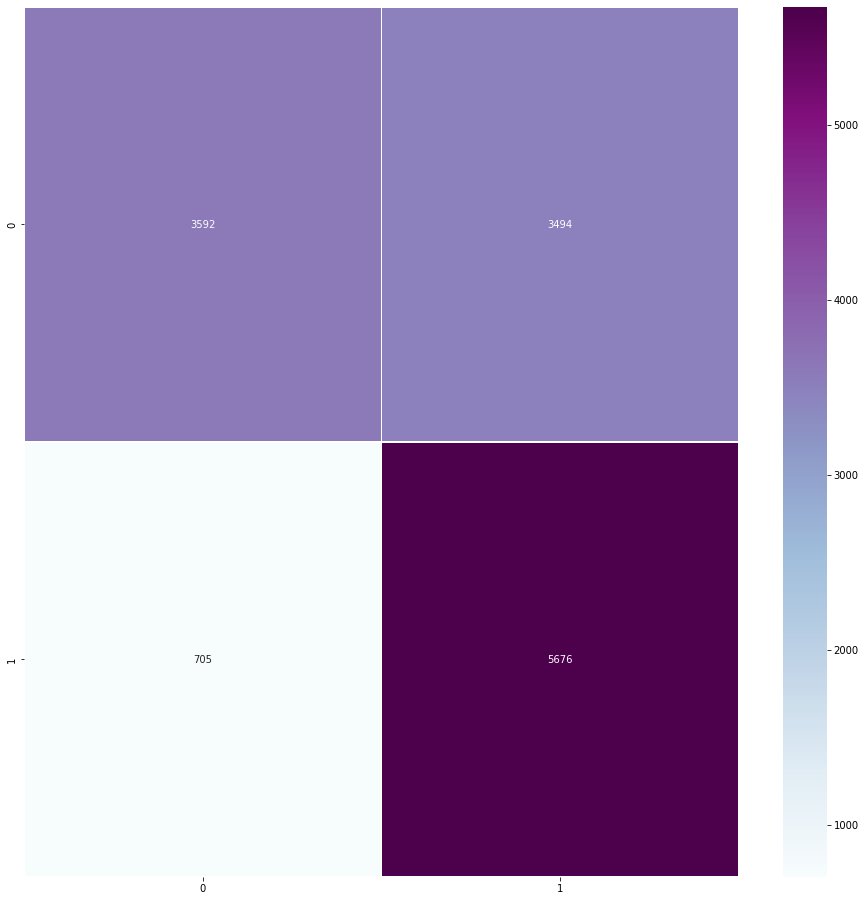

In [53]:
cm_nb1 = confusion_matrix(y_test,y_pred)

f, ax = plt.subplots(figsize=(16,16))
sns.heatmap(cm_nb1, annot=True, linewidth=0.5, fmt=".0f",  cmap='BuPu', ax = ax)
plt.xlabel = ('y_pred')
plt.ylabel = ('y_test')
from google.colab import files
plt.savefig("naive_bayes_confusion_matrix1.png")
files.download("naive_bayes_confusion_matrix1.png") 
plt.show()

# Neural Networks
Binary classifier

The Embedding layer converts sequences into arrays of word vectors and the Dense layer classifyies arrays of word vectors.

We have used the activation function sigmoid as the model is a binary classifier. 

In [54]:
max_length = 26

In [55]:
nn_model2 = Sequential() 
nn_model2.add(Embedding(19777, 8, input_length=max_length)) 
nn_model2.add(Flatten())
nn_model2.add(Dense(78, activation='relu'))
nn_model2.add(Dense(1, activation='sigmoid'))
nn_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 8)             158216    
                                                                 
 flatten (Flatten)           (None, 208)               0         
                                                                 
 dense (Dense)               (None, 78)                16302     
                                                                 
 dense_1 (Dense)             (None, 1)                 79        
                                                                 
Total params: 174,597
Trainable params: 174,597
Non-trainable params: 0
_________________________________________________________________


In [56]:
history2 = nn_model2.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
688/688 [==============================] - 4s 5ms/step - loss: 0.2430 - accuracy: 0.8975 - val_loss: 0.1264 - val_accuracy: 0.9514
Epoch 2/5
688/688 [==============================] - 3s 4ms/step - loss: 0.0663 - accuracy: 0.9774 - val_loss: 0.1267 - val_accuracy: 0.9517
Epoch 3/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0244 - accuracy: 0.9940 - val_loss: 0.1518 - val_accuracy: 0.9512
Epoch 4/5
688/688 [==============================] - 3s 4ms/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.1806 - val_accuracy: 0.9474
Epoch 5/5
688/688 [==============================] - 3s 4ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.2114 - val_accuracy: 0.9430


In [57]:
model_loss, model_accuracy = nn_model2.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

Loss: 0.1889561265707016, Accuracy: 0.945050835609436


Confusion Matrix

In [ ]:
#cm_nn1 = confusion_matrix(y_pred, y_test)

#f, ax = plt.subplots(figsize=(16,16))
#sns.heatmap(cm_nn1, annot=True, linewidth=0.5, fmt=".0f",  cmap='BuPu_r', ax = ax)
#plt.xlabel = ('y_pred')
#plt.ylabel = ('y_test')
#from google.colab import files
#plt.savefig("nn_confusion_matrix1.png")
#files.download("nn_confusion_matrix1.png") 
#plt.show()

# Model Optimization

In [58]:
# Neural Networks Model  - binary classifier
# Create the model 
nn_model = Sequential() 
nn_model.add(Embedding(19777, 8, input_length=max_length)) 
nn_model.add(Flatten())
nn_model.add(Dense(52, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 8)             158216    
                                                                 
 flatten_1 (Flatten)         (None, 208)               0         
                                                                 
 dense_2 (Dense)             (None, 52)                10868     
                                                                 
 dense_3 (Dense)             (None, 1)                 53        
                                                                 
Total params: 169,137
Trainable params: 169,137
Non-trainable params: 0
_________________________________________________________________


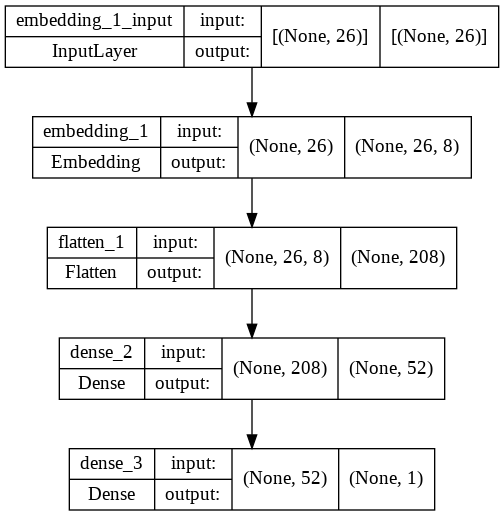

In [59]:
keras.utils.plot_model(nn_model, "nn_optimized.png", show_shapes=True)

In [60]:
# Train the model 
history = nn_model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
688/688 [==============================] - 4s 5ms/step - loss: 0.2562 - accuracy: 0.8950 - val_loss: 0.1389 - val_accuracy: 0.9414
Epoch 2/5
688/688 [==============================] - 3s 4ms/step - loss: 0.0682 - accuracy: 0.9761 - val_loss: 0.1246 - val_accuracy: 0.9531
Epoch 3/5
688/688 [==============================] - 3s 5ms/step - loss: 0.0256 - accuracy: 0.9929 - val_loss: 0.1486 - val_accuracy: 0.9500
Epoch 4/5
688/688 [==============================] - 5s 7ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.1705 - val_accuracy: 0.9502
Epoch 5/5
688/688 [==============================] - 9s 13ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 0.1915 - val_accuracy: 0.9484


# Model Evaluation

In [61]:
# Evaluate the model using the test data
y_pred = nn_model.predict(X_test)

model_loss, model_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

Loss: 0.1730300933122635, Accuracy: 0.950397253036499


Confusion Matrix

In [ ]:
#cm_mo1 = confusion_matrix(y_pred2, y_test)

#f, ax = plt.subplots(figsize=(16,16))
#sns.heatmap(cm_mo1, annot=True, linewidth=0.5, fmt=".0f",  cmap='BuPu_r', ax = ax)
#plt.xlabel = ('y_pred')
#plt.ylabel = ('y_test')
#from google.colab import files
#plt.savefig("mo_confusion_matrix1.png")
#files.download("mo_confusion_matrix1.png") 
#plt.show()

[]

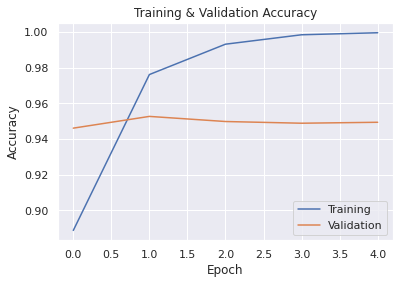

In [ ]:
%matplotlib inline
sns.set()

acc = history.history['accuracy']
val = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, '-', label='Training')
plt.plot(val, '-', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

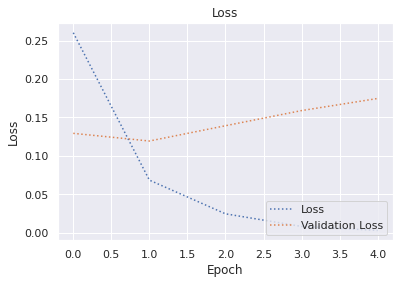

In [ ]:
plt.plot(loss, ':', label='Loss')
plt.plot(val_loss, ':', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

The Loss plot shows a good leaning rate. The vallidation loss starts increase slighlty after the first epoch but still remains low. The low loss rate and high accuracy rate in addition to the slight increase in the validation loss suggests that model might potentially be over-fitting on the training data.

In [ ]:
# Overfitting data?

# Model Testing
We wanted to see if our model would work on unseen brand new data. We found two article headlines from recent weeks:

TRUE
'China Signals Missile Launch Over Taiwan' from USNEWS (3 Aug 2022)

FAKE
'Throughout the summer Democrats cruelly blocked COVID relief legislation in an effort to advance their extreme left-wing agenda and influence the election' from Washington Post (DEC 22 2020)

In [ ]:
# True News: Clean, tokenize, sequence & predict
true_test_lower = lower_title('China Signals Missile Launch Over Taiwan')
true_test_clean = remove_stop_words(true_test_lower)
sequence = tokenizer.texts_to_sequences([true_test_clean])
padded_sequence = pad_sequences(sequence, maxlen=26)
nn_model.predict(padded_sequence)[0][0]

0.9760783

In [ ]:
# Fake News: Clean, tokenize, sequence & predict
fake_test_lower = lower_title('Throughout the summer Democrats cruelly blocked COVID relief legislation in an effort to advance their extreme left-wing agenda and influence the election')
fake_test_clean = remove_stop_words(fake_test_lower)
sequence = tokenizer.texts_to_sequences([fake_test_clean])
padded_sequence2 = pad_sequences(sequence, maxlen=26)
nn_model.predict(padded_sequence2)[0][0]

0.00010593174

The model predicts that this qoute from Trump is false. This quote is indeed false which shows that our model works. 

Variations of this text was repeated by Trump 31 times. The implicatiosn for democracy and public health are explicit.